In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv')
covid_19_df['Date'] = pd.to_datetime(covid_19_df['Date'])
covid_19_df['Country/Region'] = covid_19_df['Country/Region'].replace('Mainland China', 'China')
covid_19_df.tail(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
19218,NaN,The Bahamas,24.2500,-76.0,2020-03-23,0.0,0.0,0.0
19219,NaN,The Gambia,13.4667,-16.6,2020-03-23,0.0,0.0,0.0


In [4]:
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
growth = ['Confirmed_growth', 'Deaths_growth', 'Recovered_growth', 'Confirmed_growth_mean']
covid_19_df['Active'] = covid_19_df['Confirmed'] - covid_19_df['Deaths'] - covid_19_df['Recovered']
covid_19_df = covid_19_df.sort_values(by=['Date'], ascending=True)
covid_19_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Thailand,15.0,101.00,2020-01-22,2.0,0.0,0.0,2.0
210,NaN,Guyana,5.0,-58.75,2020-01-22,0.0,0.0,0.0,0.0


### Finding Countries with most confirmed cases

In [5]:
last_covid_df = covid_19_df[covid_19_df['Date'] == covid_19_df['Date'].max()].reset_index(drop=True)
last_covid_df = last_covid_df.drop(columns=['Lat', 'Long'])
top_50 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(50)
top_50.head(2)

,Confirmed,Deaths,Recovered,Active
Country/Region,,,,
China,81439.0,3274.0,72814.0,5351.0
Italy,59138.0,5476.0,7024.0,46638.0


In [6]:
def prepare_data(df, country, *lower_bound):
    df = df[df['Country/Region'] == country]
    if (country == 'China') | (country == 'US') | (country == 'Australia') | (country == 'Canada') | (country == 'Denmark'):
        df = df.groupby('Date').sum().reset_index()
    elif df[df['Province/State'] == country].notna().any().any():
        df = df[df['Province/State'] == country]
    df = df.sort_values(by='Date').reset_index(drop=True)

    if lower_bound:
        df = df[df.Confirmed > lower_bound].reset_index(drop=True)
    date_range = df['Date'].sort_values().drop_duplicates().reset_index(drop=True)
    date_range = date_range.dt.strftime('%d-%m')
    return df, date_range

In [7]:
def show_increment(df, label, date_range):
    my_xticks = range(0, len(date_range), 5)
    my_xticks_labels = list(date_range)[0:len(date_range):5]
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax1 = sns.lineplot(data=df[cases], ax=ax)
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel(label)
    plt.show()
    
    print('\nDaily growth for each types of cases\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(23, 5))
    ax1 = sns.barplot(x=date_range.index, y='Confirmed_growth', data=df, ax=ax1, palette=cm.Blues(df.Confirmed_growth/max(df.Confirmed_growth*1.5)+0.3))
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel('Daily Confirmed growth')
    ax1.set_ylabel('Cases')
    
    ax2 = sns.barplot(x=date_range.index, y='Deaths_growth', data=df, ax=ax2, palette=cm.autumn_r(df.Deaths_growth/max(df.Deaths_growth*1.5)+0.3))
    ax2.set_xticks(my_xticks)
    ax2.set_xticklabels(my_xticks_labels)
    ax2.set_xlabel('Daily Deaths growth')
    ax2.set_ylabel('Cases')
    
    ax3 = sns.barplot(x=date_range.index, y='Recovered_growth', data=df, ax=ax3, palette=cm.Greens(df.Recovered_growth/max(df.Recovered_growth)+0.3))
    ax3.set_xticks(my_xticks)
    ax3.set_xticklabels(my_xticks_labels)
    ax3.set_xlabel('Daily Recovered growth')
    ax3.set_ylabel('Cases')
    
    plt.show()

In [8]:
def add_data(covid_19_df):
    covid_19_df['Confirmed_growth'] = covid_19_df['Confirmed'] - covid_19_df['Confirmed'].shift()
    covid_19_df['Confirmed_growth'][0] = covid_19_df['Confirmed'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Deaths_growth'] = covid_19_df['Deaths'] - covid_19_df['Deaths'].shift()
    covid_19_df['Deaths_growth'][0] = covid_19_df['Deaths'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Recovered_growth'] = covid_19_df['Recovered'] - covid_19_df['Recovered'].shift()
    covid_19_df['Recovered_growth'][0] = covid_19_df['Recovered'][0]
    covid_19_df = covid_19_df.fillna(0)
    return covid_19_df

### Plots for 50 countries with most confirmed cases with start data: 50 confirmed cases

The line plot presents all data in the following days starting from the moment when there were more than 50 confirmed cases.<br>
The bar plots show the daily increase in each category. There are some days with negative values caused by changes in the data tables in the source data - maybe some of the cases were wrongly classified as recovered and therefore were removed. 

1 . China
Confirmed: 81439.0 
Active: 5351.0 
Recovered: 72814.0 
Deaths: 3274.0


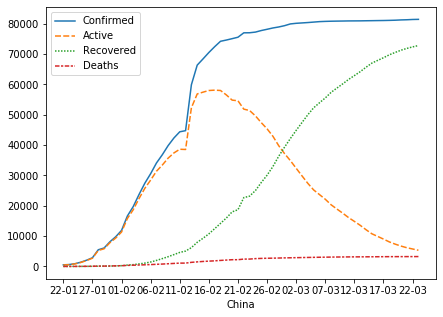


Daily growth for each types of cases



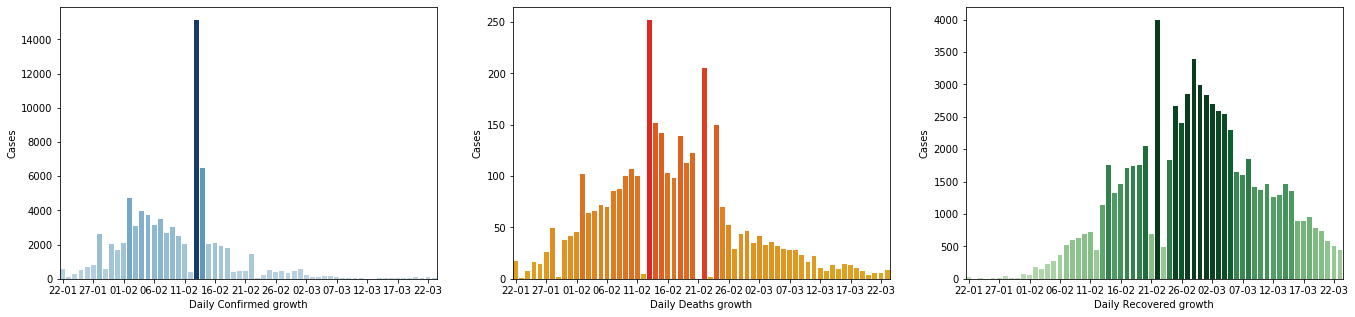

2 . Italy
Confirmed: 59138.0 
Active: 46638.0 
Recovered: 7024.0 
Deaths: 5476.0


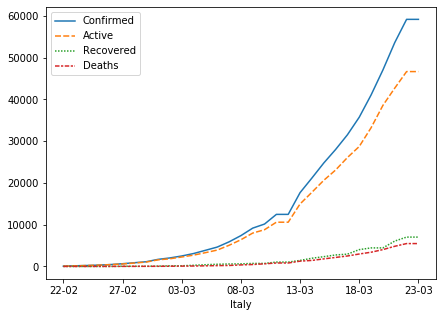


Daily growth for each types of cases



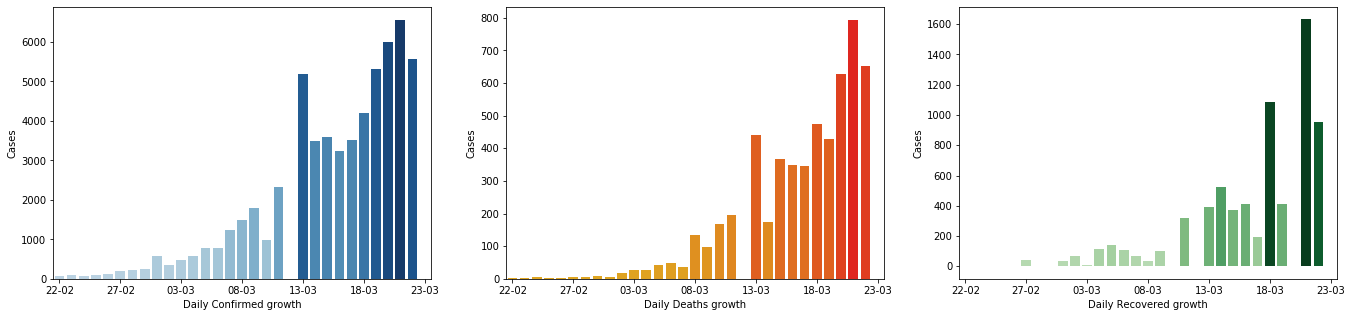

3 . US
Confirmed: 33276.0 
Active: 32681.0 
Recovered: 178.0 
Deaths: 417.0


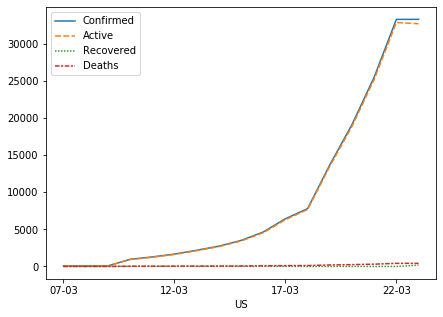


Daily growth for each types of cases



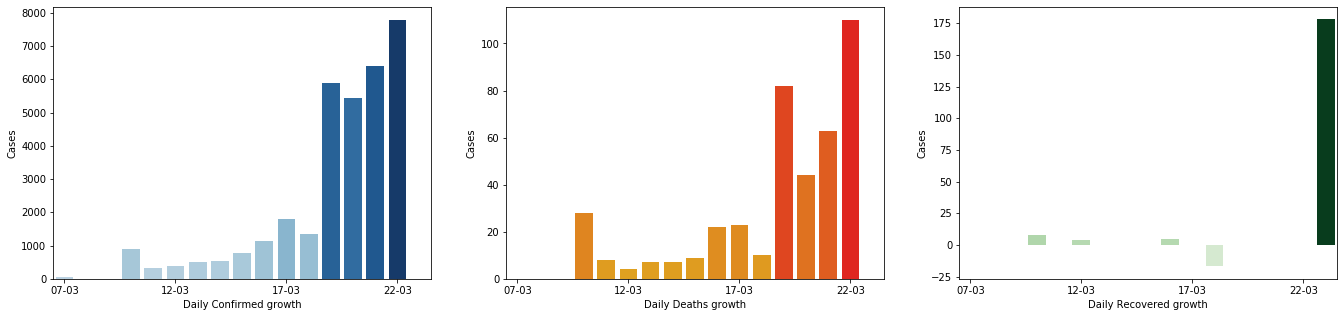

4 . Spain
Confirmed: 28768.0 
Active: 24421.0 
Recovered: 2575.0 
Deaths: 1772.0


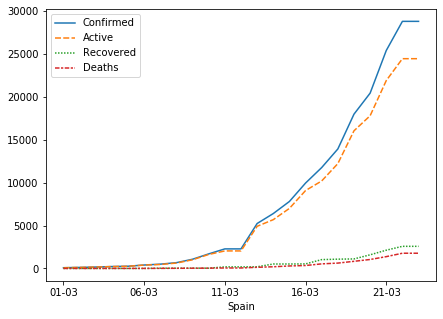


Daily growth for each types of cases



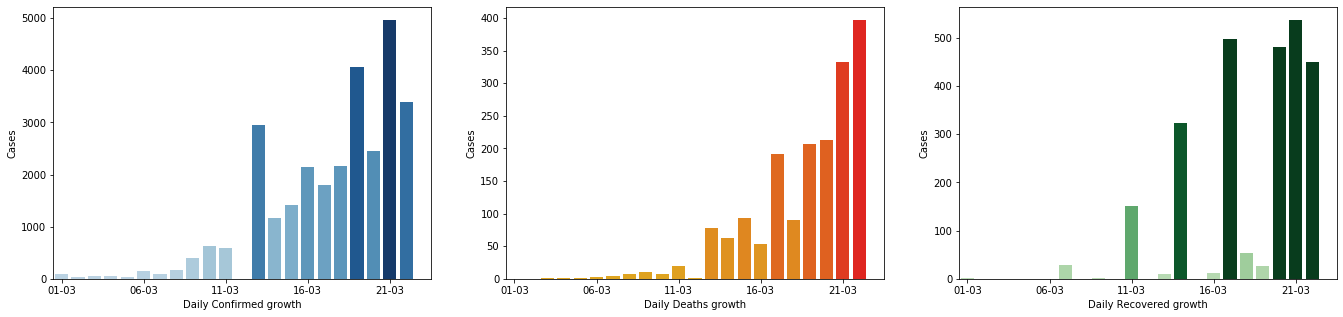

5 . Germany
Confirmed: 24873.0 
Active: 24513.0 
Recovered: 266.0 
Deaths: 94.0


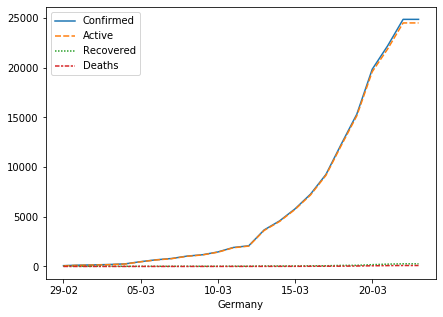


Daily growth for each types of cases



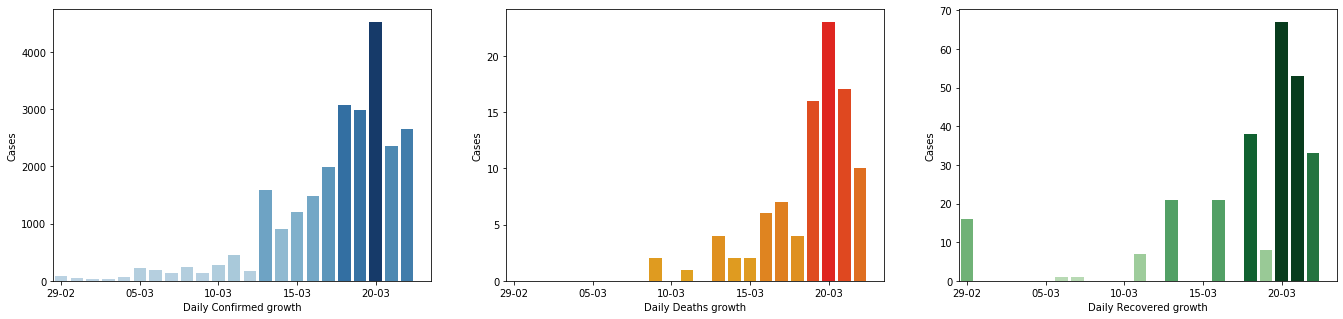

6 . Iran
Confirmed: 21638.0 
Active: 12022.0 
Recovered: 7931.0 
Deaths: 1685.0


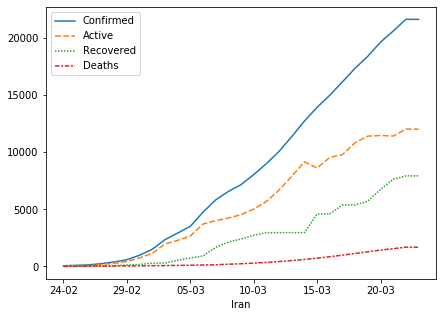


Daily growth for each types of cases



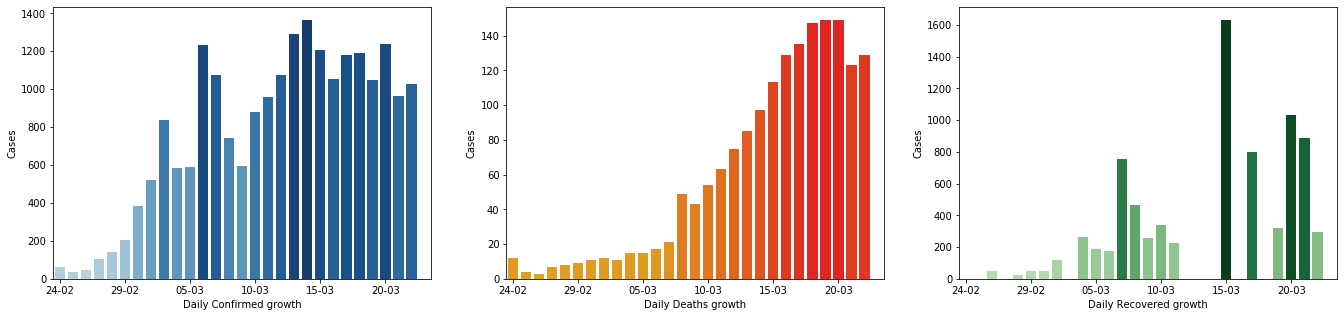

7 . France
Confirmed: 16044.0 
Active: 13170.0 
Recovered: 2200.0 
Deaths: 674.0


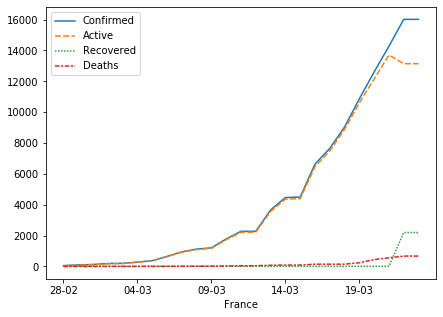


Daily growth for each types of cases



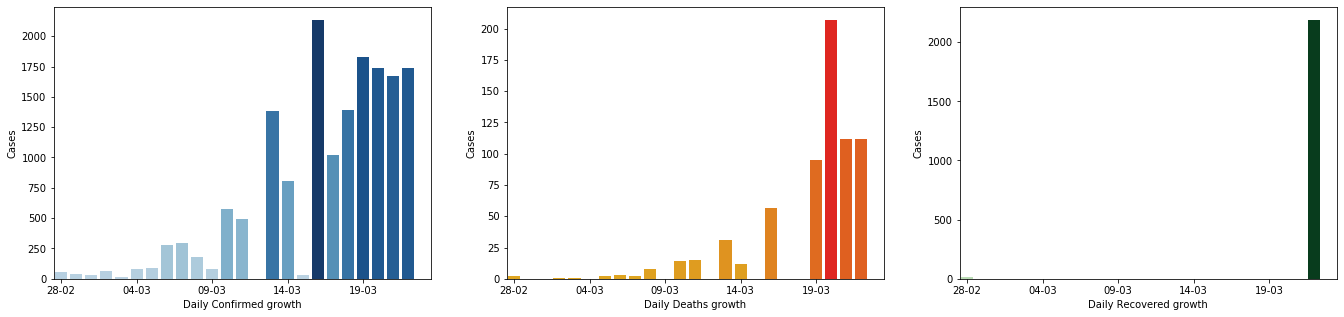

8 . Korea, South
Confirmed: 8897.0 
Active: 5884.0 
Recovered: 2909.0 
Deaths: 104.0


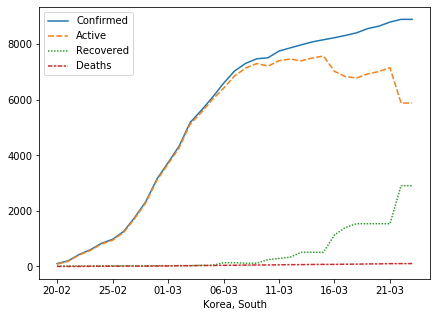


Daily growth for each types of cases



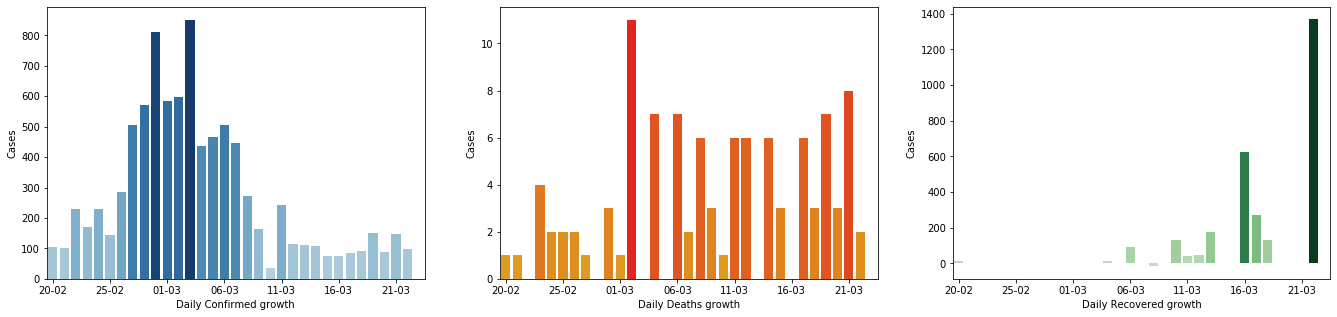

9 . Switzerland
Confirmed: 7245.0 
Active: 7016.0 
Recovered: 131.0 
Deaths: 98.0


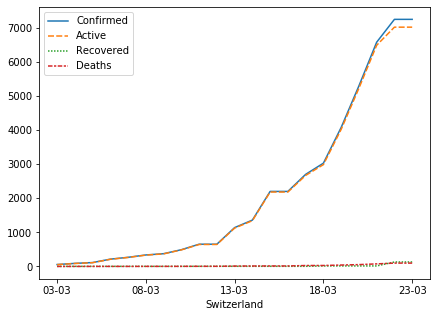


Daily growth for each types of cases



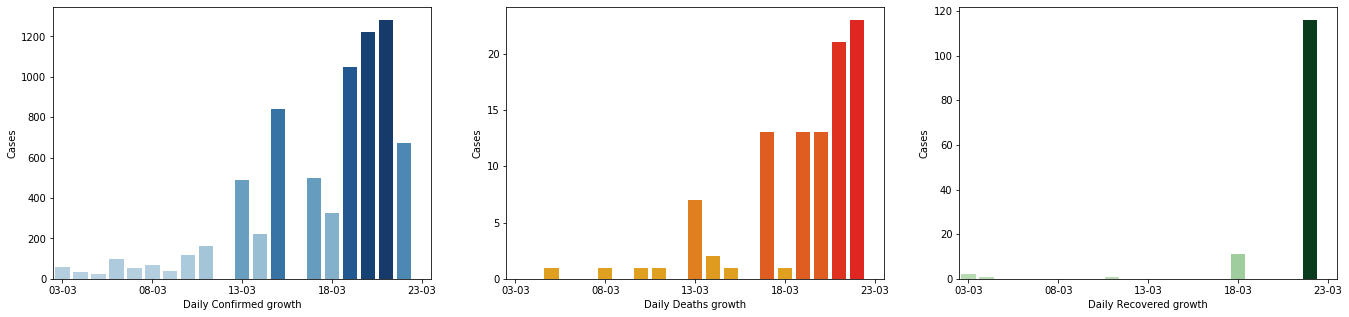

10 . United Kingdom
Confirmed: 5741.0 
Active: 5392.0 
Recovered: 67.0 
Deaths: 282.0


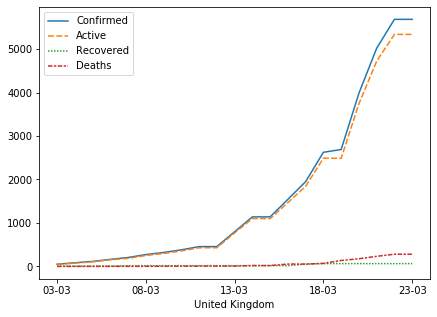


Daily growth for each types of cases



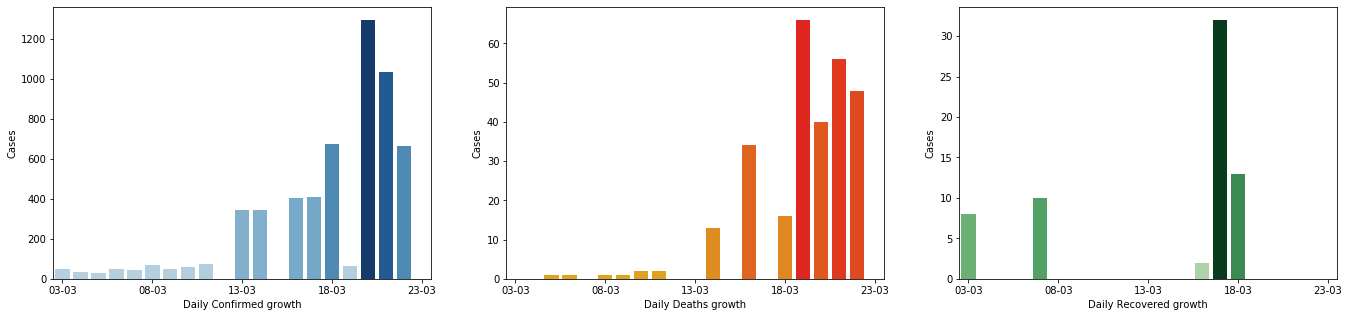

11 . Netherlands
Confirmed: 4216.0 
Active: 4034.0 
Recovered: 2.0 
Deaths: 180.0


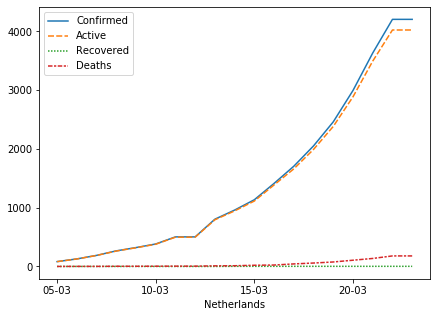


Daily growth for each types of cases



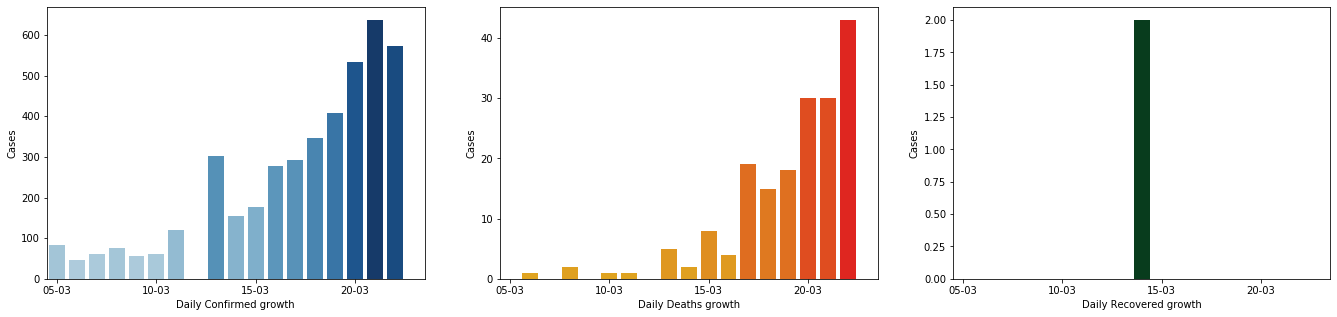

12 . Belgium
Confirmed: 3401.0 
Active: 3063.0 
Recovered: 263.0 
Deaths: 75.0


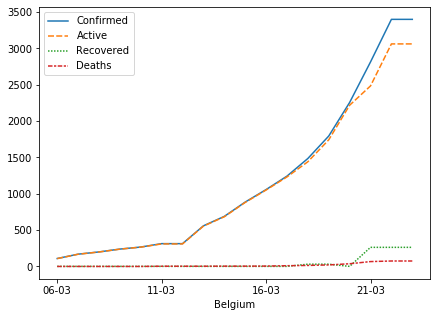


Daily growth for each types of cases



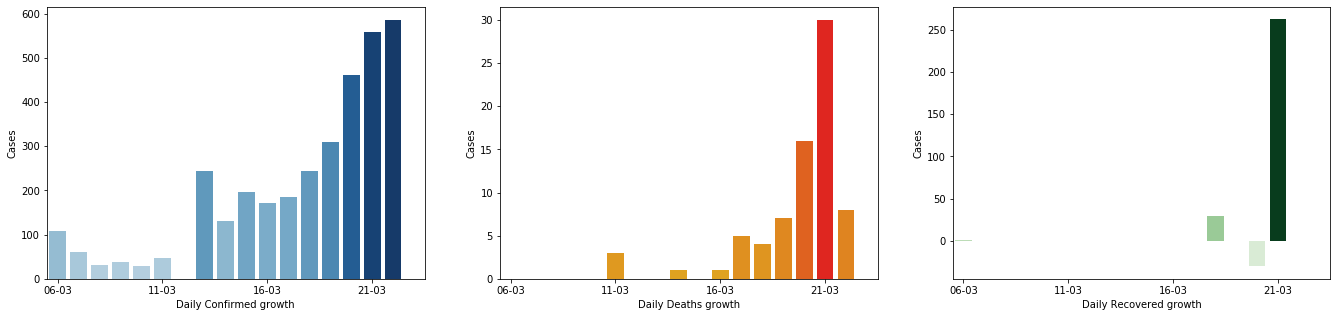

13 . Austria
Confirmed: 3244.0 
Active: 3219.0 
Recovered: 9.0 
Deaths: 16.0


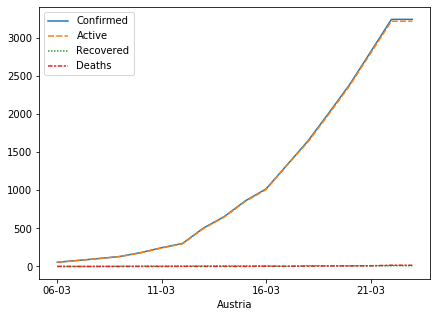


Daily growth for each types of cases



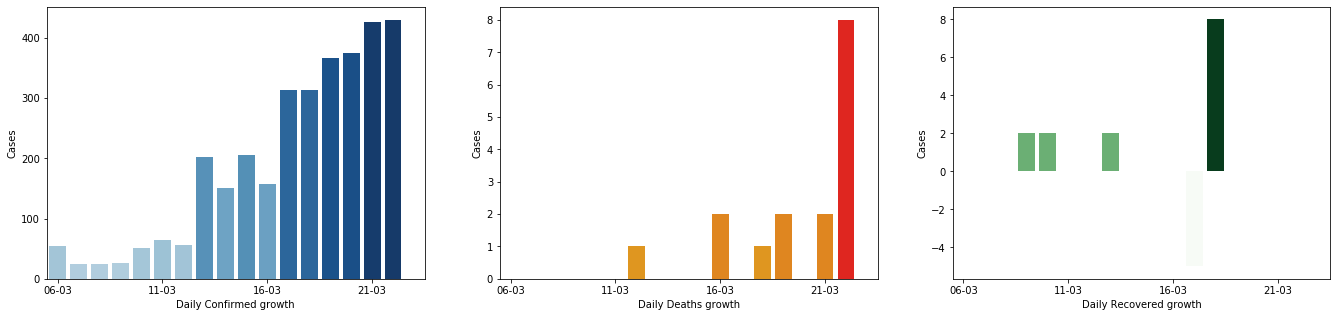

14 . Norway
Confirmed: 2383.0 
Active: 2375.0 
Recovered: 1.0 
Deaths: 7.0


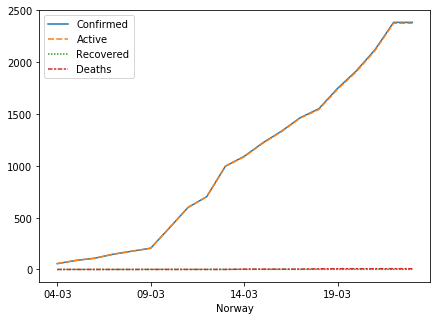


Daily growth for each types of cases



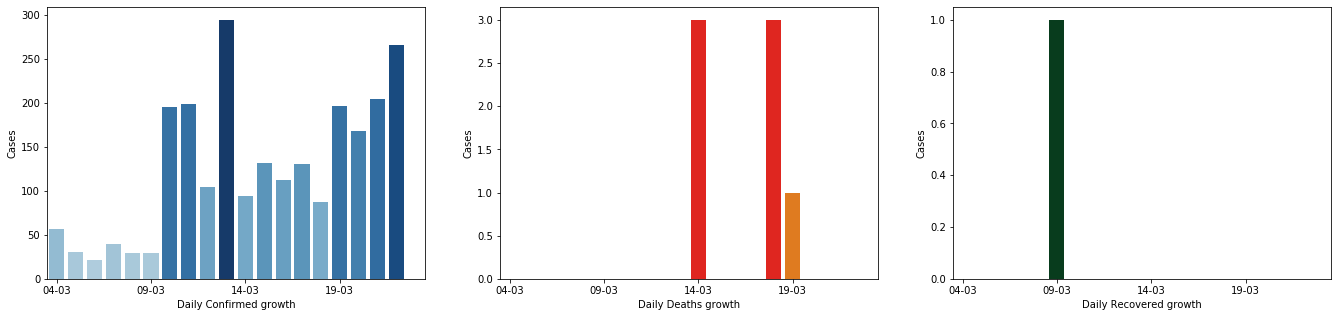

15 . Sweden
Confirmed: 1934.0 
Active: 1897.0 
Recovered: 16.0 
Deaths: 21.0


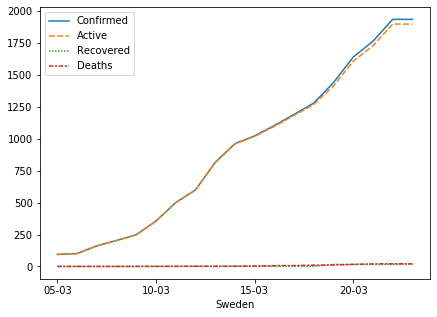


Daily growth for each types of cases



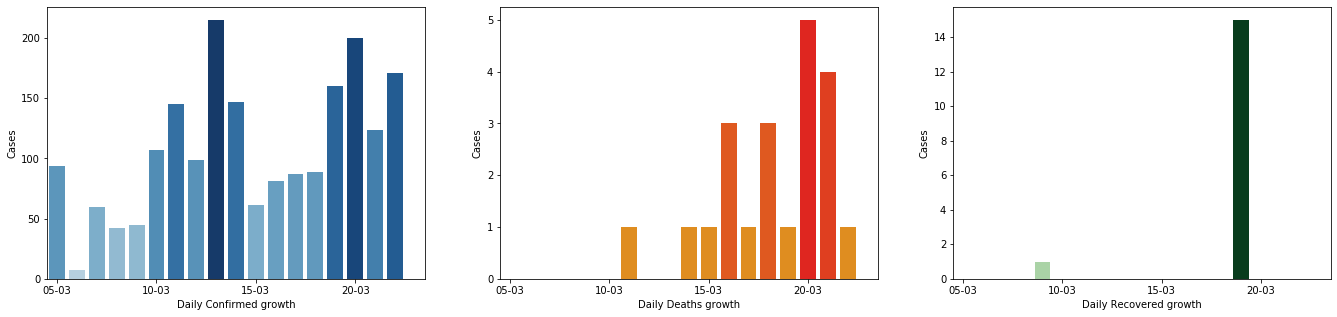

16 . Portugal
Confirmed: 1600.0 
Active: 1581.0 
Recovered: 5.0 
Deaths: 14.0


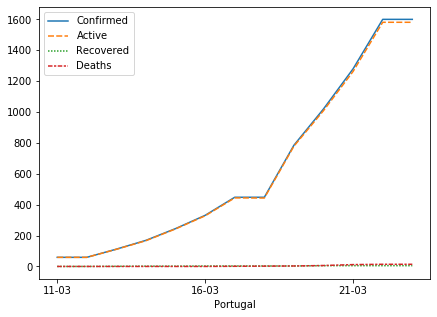


Daily growth for each types of cases



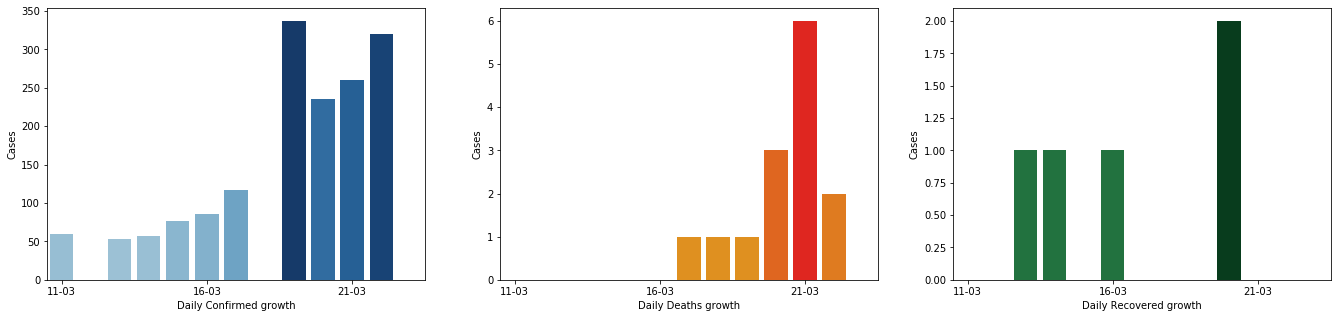

17 . Brazil
Confirmed: 1593.0 
Active: 1566.0 
Recovered: 2.0 
Deaths: 25.0


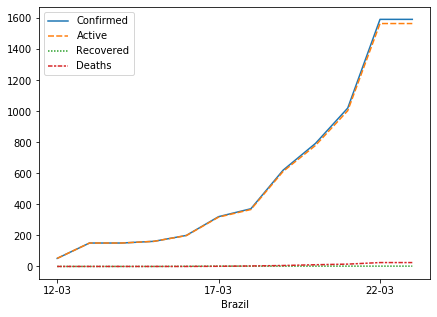


Daily growth for each types of cases



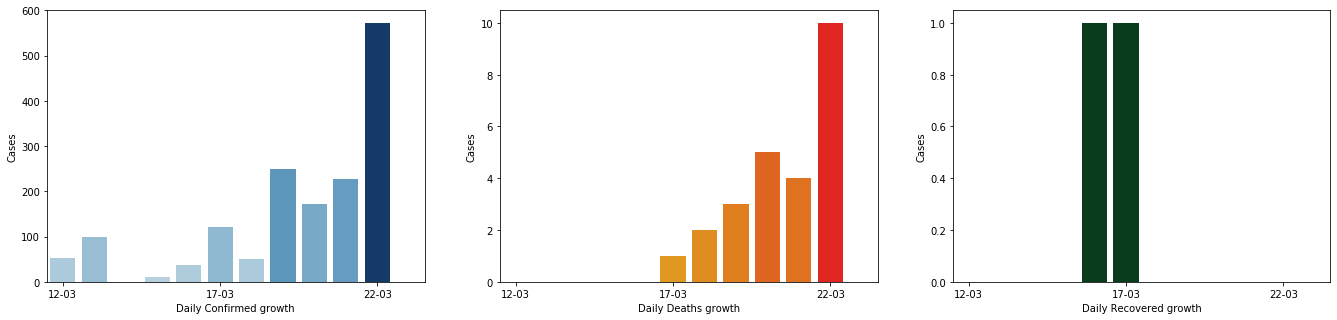

18 . Denmark
Confirmed: 1514.0 
Active: 1500.0 
Recovered: 1.0 
Deaths: 13.0


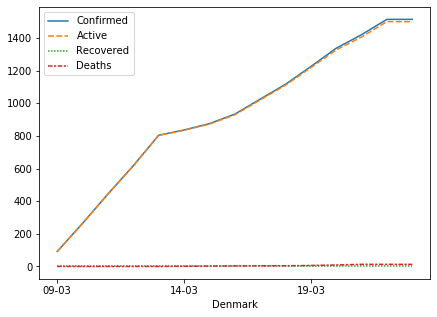


Daily growth for each types of cases



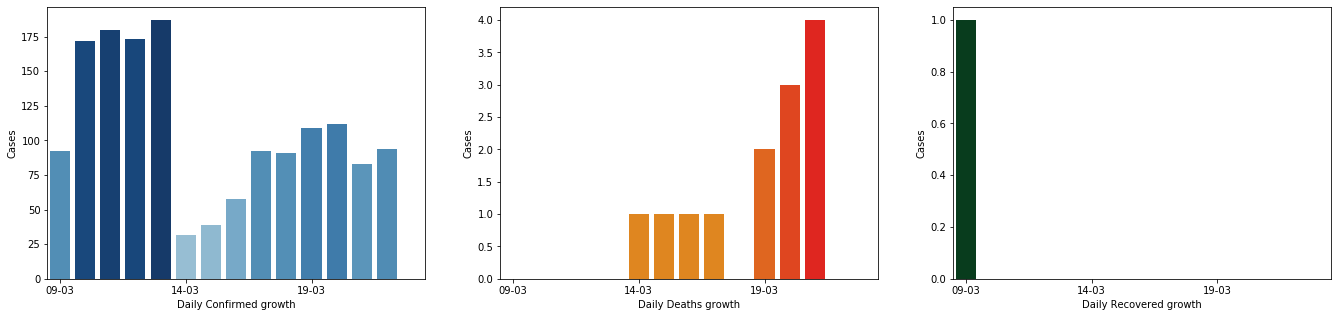

19 . Canada
Confirmed: 1470.0 
Active: 1439.0 
Recovered: 10.0 
Deaths: 21.0


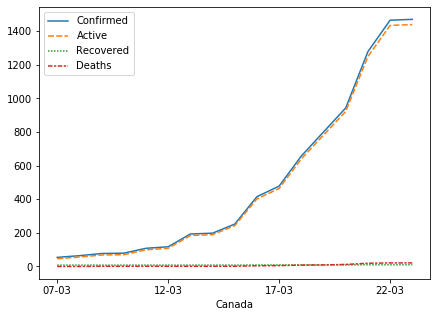


Daily growth for each types of cases



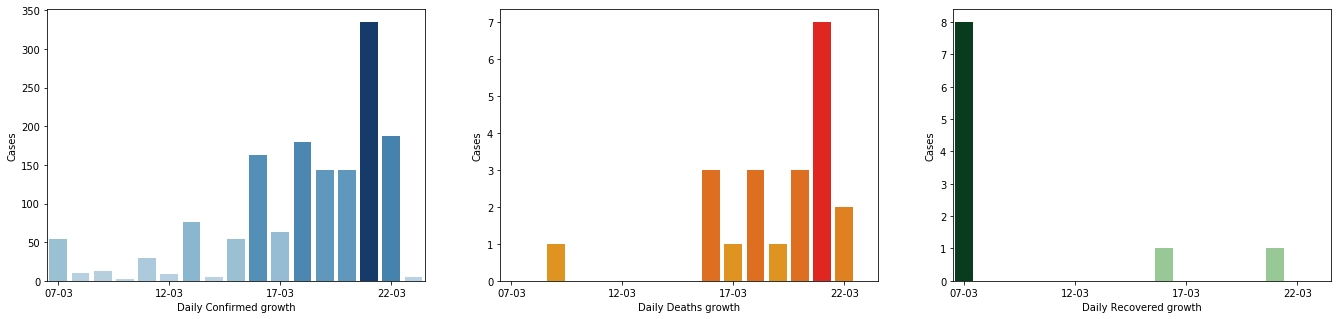

20 . Australia
Confirmed: 1314.0 
Active: 1219.0 
Recovered: 88.0 
Deaths: 7.0


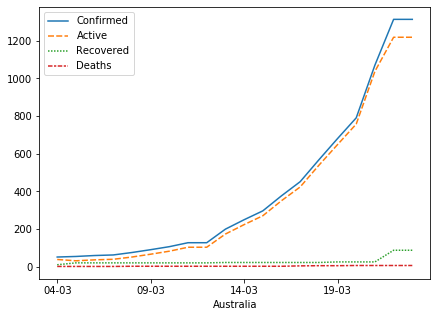


Daily growth for each types of cases



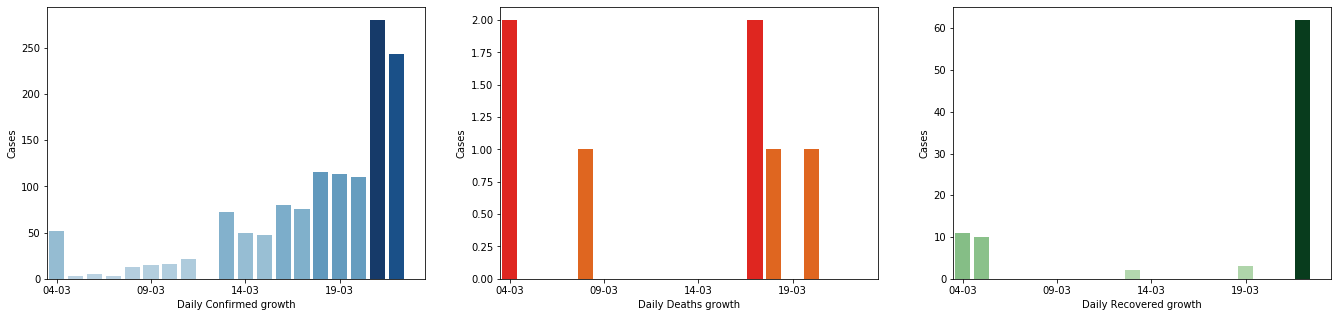

21 . Malaysia
Confirmed: 1306.0 
Active: 1157.0 
Recovered: 139.0 
Deaths: 10.0


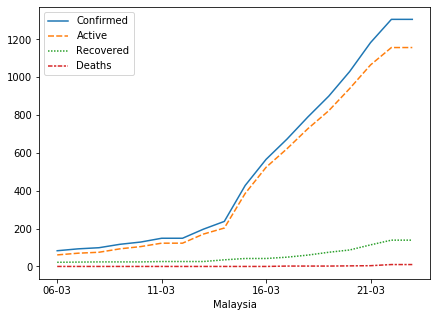


Daily growth for each types of cases



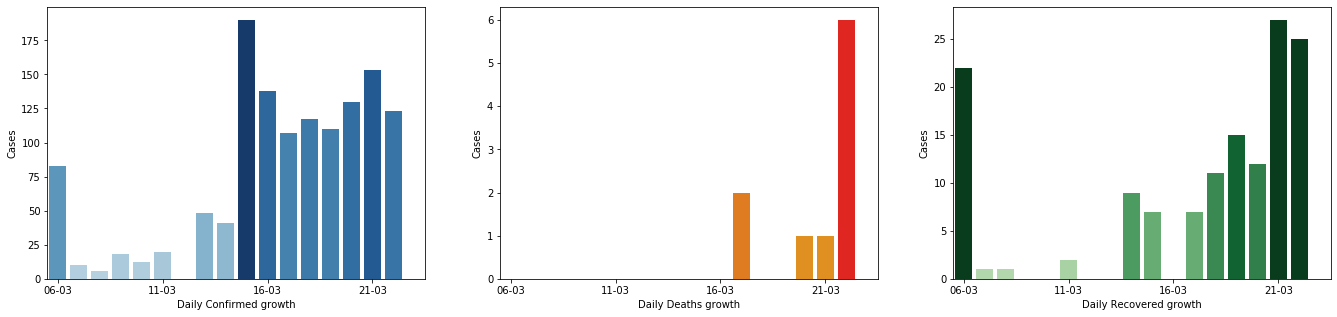

22 . Turkey
Confirmed: 1236.0 
Active: 1206.0 
Recovered: 0.0 
Deaths: 30.0


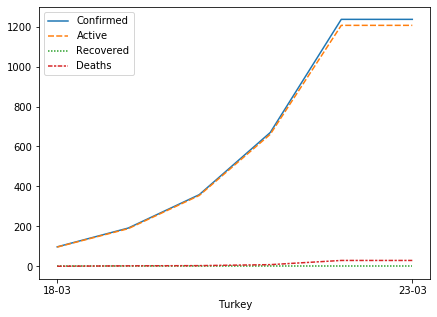


Daily growth for each types of cases



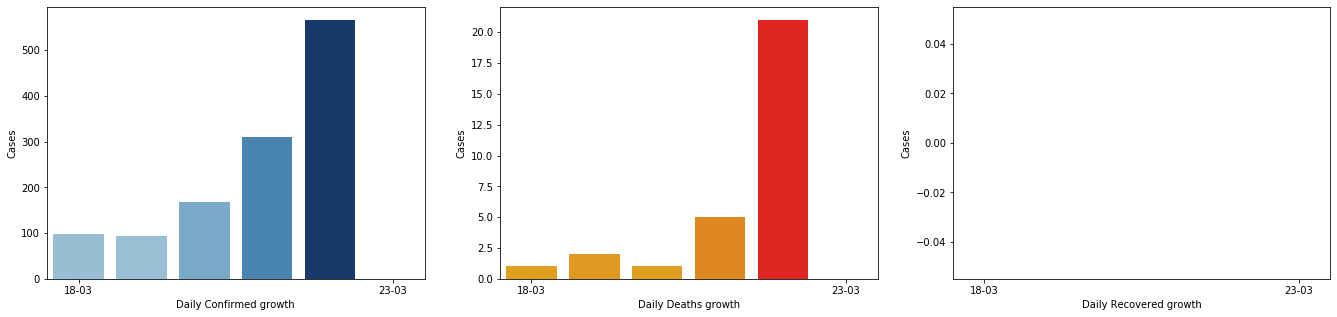

23 . Czechia
Confirmed: 1120.0 
Active: 1113.0 
Recovered: 6.0 
Deaths: 1.0


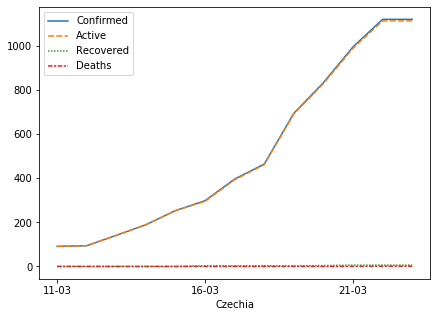


Daily growth for each types of cases



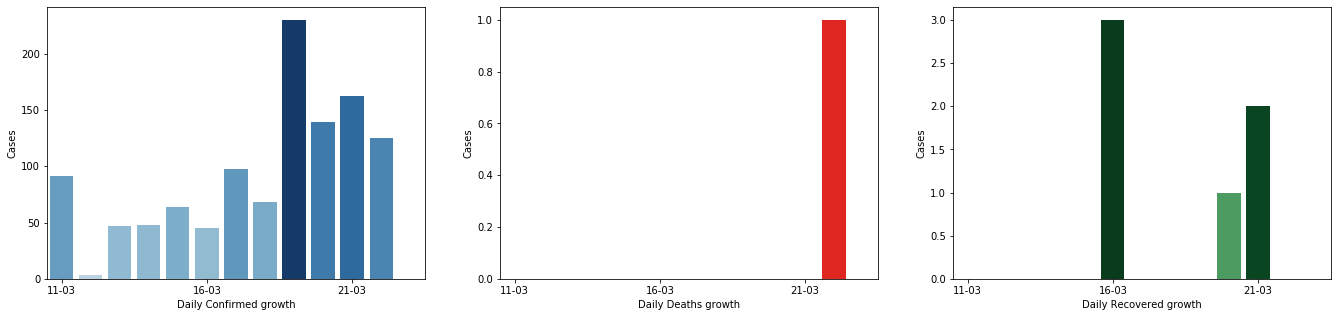

24 . Japan
Confirmed: 1086.0 
Active: 811.0 
Recovered: 235.0 
Deaths: 40.0


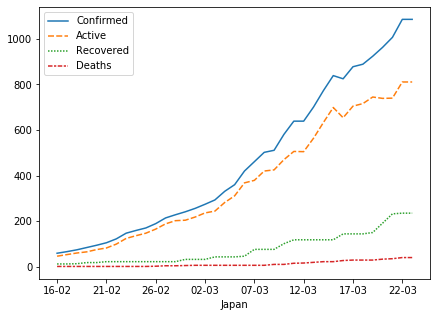


Daily growth for each types of cases



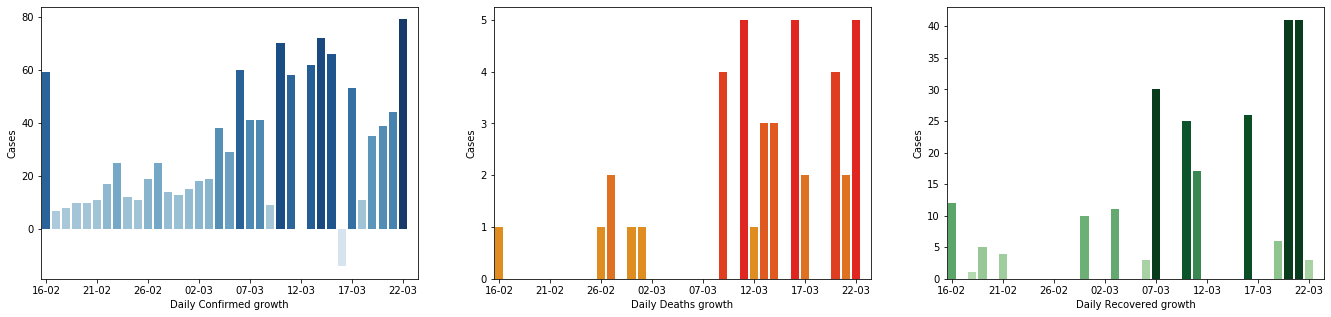

25 . Israel
Confirmed: 1071.0 
Active: 1033.0 
Recovered: 37.0 
Deaths: 1.0


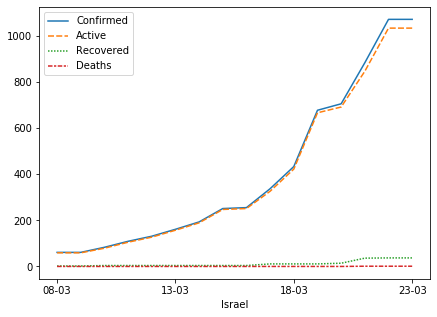


Daily growth for each types of cases



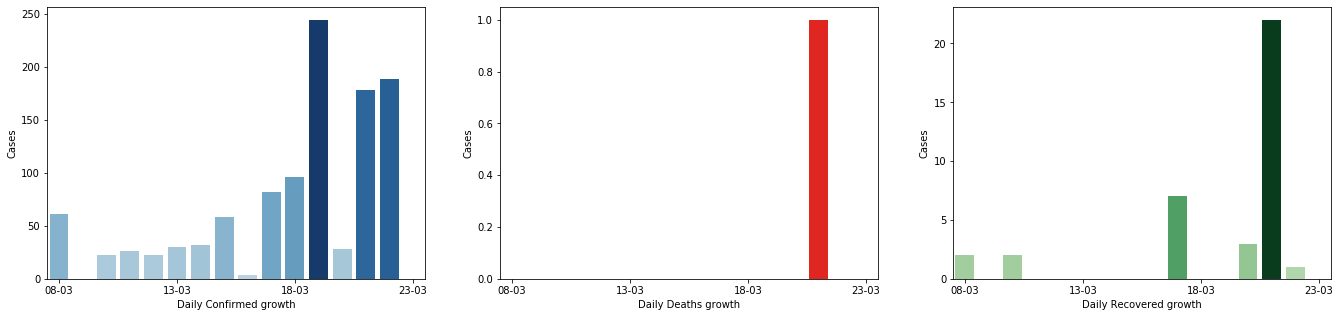

26 . Ireland
Confirmed: 906.0 
Active: 897.0 
Recovered: 5.0 
Deaths: 4.0


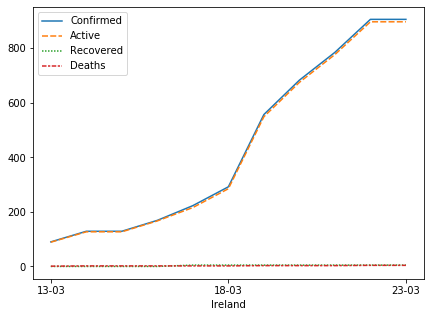


Daily growth for each types of cases



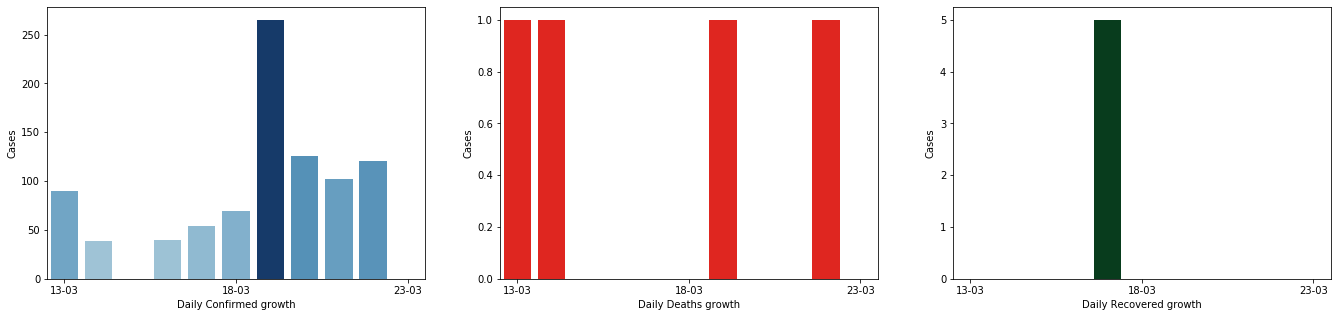

27 . Luxembourg
Confirmed: 798.0 
Active: 784.0 
Recovered: 6.0 
Deaths: 8.0


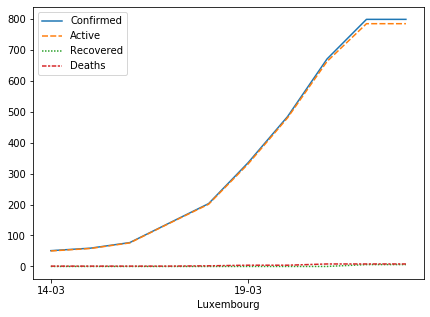


Daily growth for each types of cases



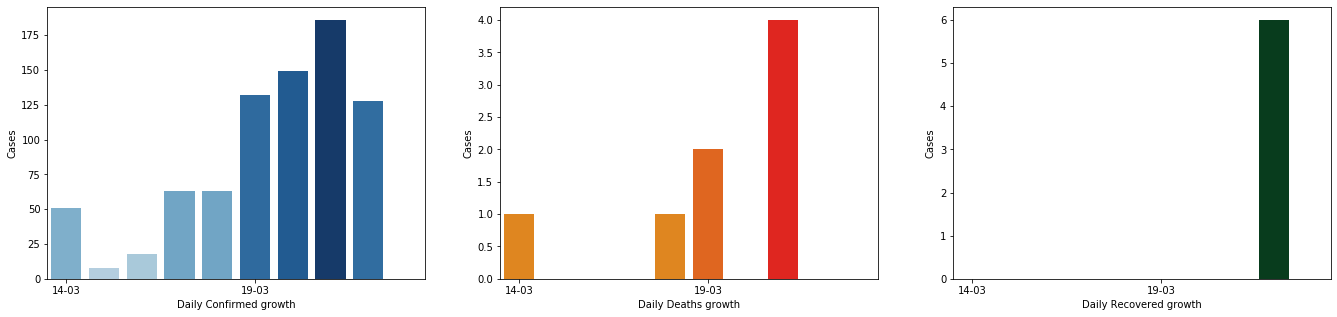

28 . Ecuador
Confirmed: 789.0 
Active: 772.0 
Recovered: 3.0 
Deaths: 14.0


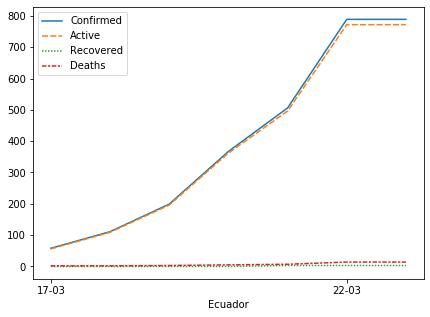


Daily growth for each types of cases



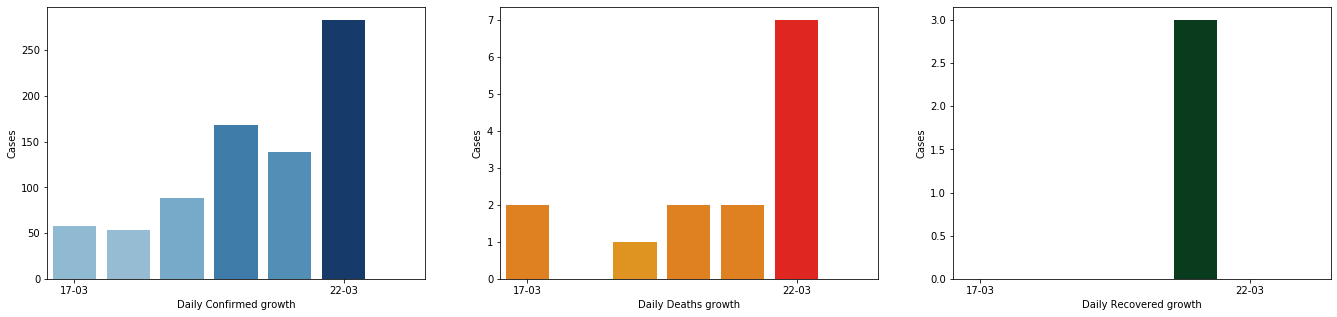

29 . Pakistan
Confirmed: 776.0 
Active: 766.0 
Recovered: 5.0 
Deaths: 5.0


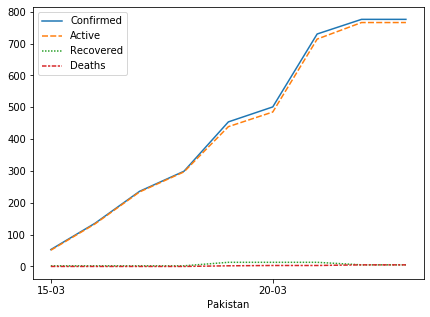


Daily growth for each types of cases



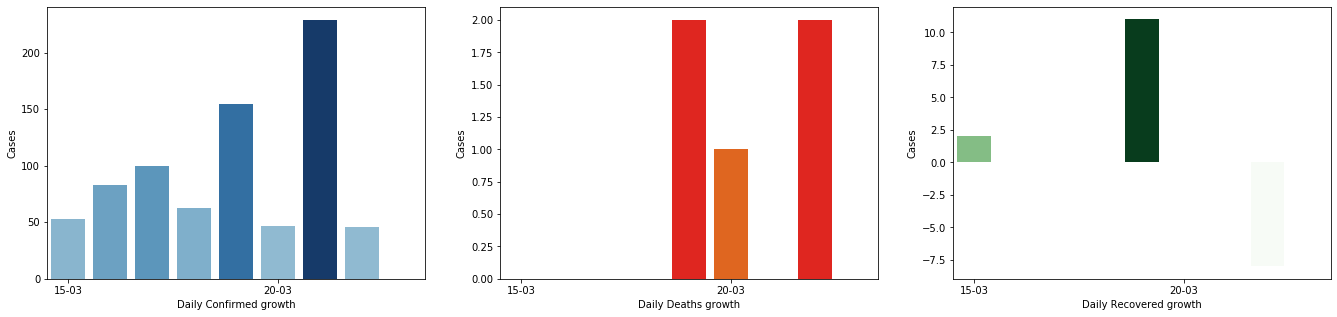

30 . Cruise Ship
Confirmed: 712.0 
Active: 379.0 
Recovered: 325.0 
Deaths: 8.0


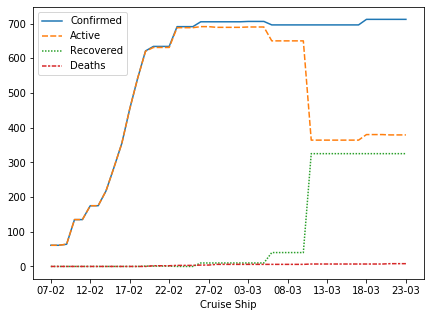


Daily growth for each types of cases



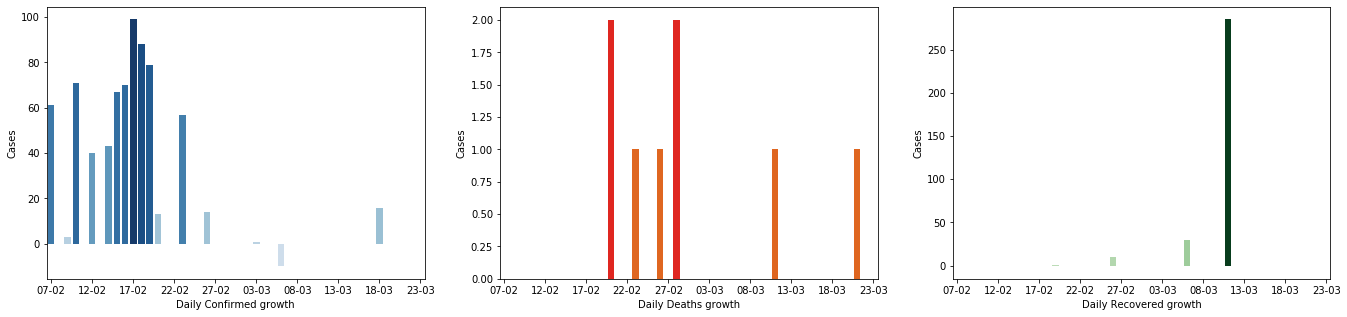

31 . Poland
Confirmed: 634.0 
Active: 626.0 
Recovered: 1.0 
Deaths: 7.0


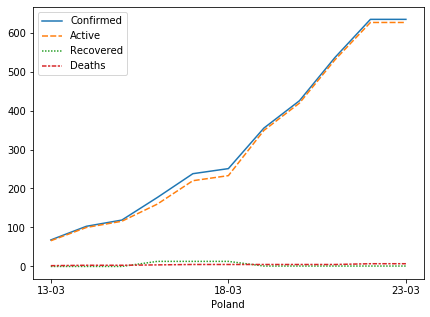


Daily growth for each types of cases



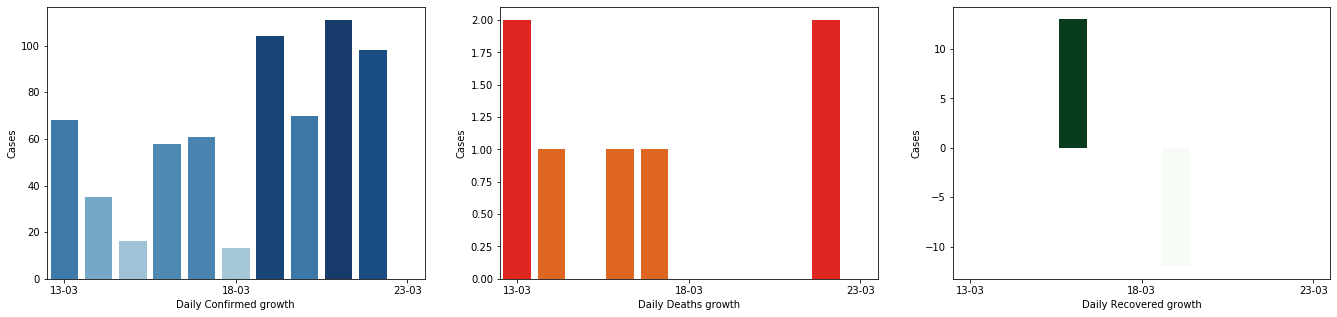

32 . Chile
Confirmed: 632.0 
Active: 623.0 
Recovered: 8.0 
Deaths: 1.0


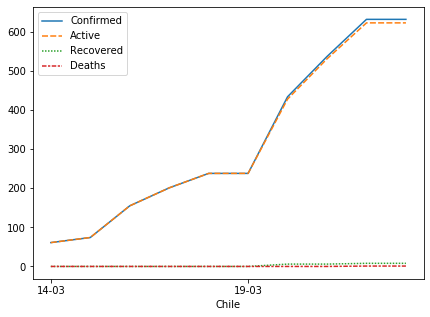


Daily growth for each types of cases



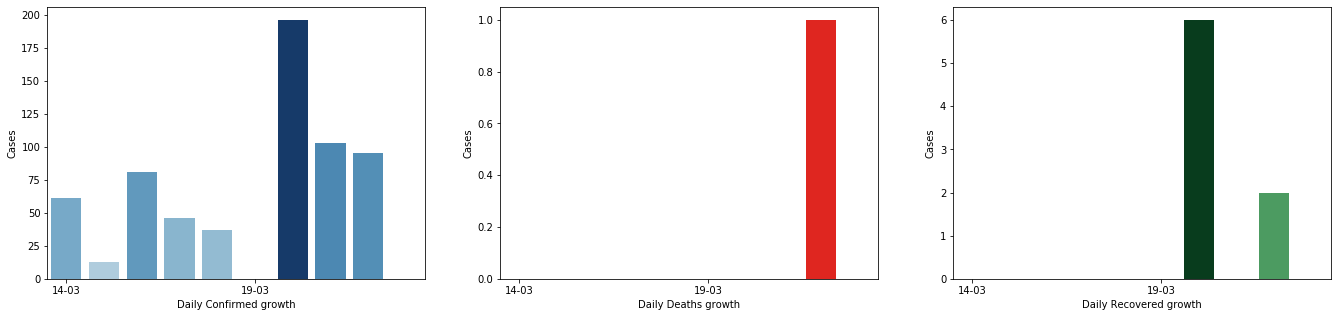

33 . Finland
Confirmed: 626.0 
Active: 615.0 
Recovered: 10.0 
Deaths: 1.0


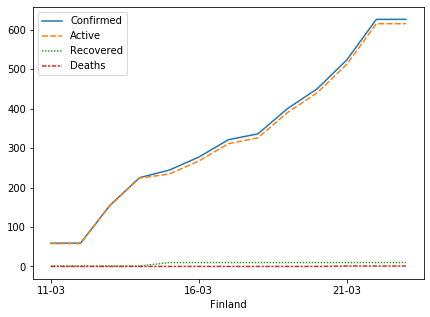


Daily growth for each types of cases



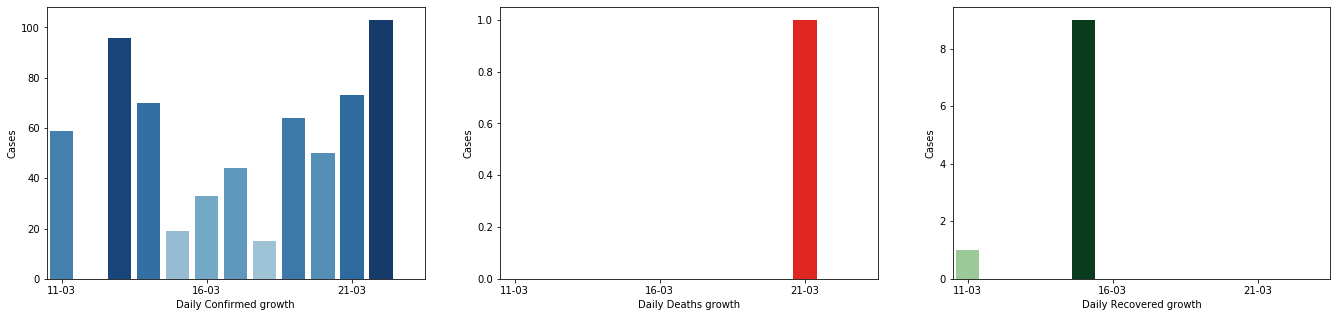

34 . Greece
Confirmed: 624.0 
Active: 590.0 
Recovered: 19.0 
Deaths: 15.0


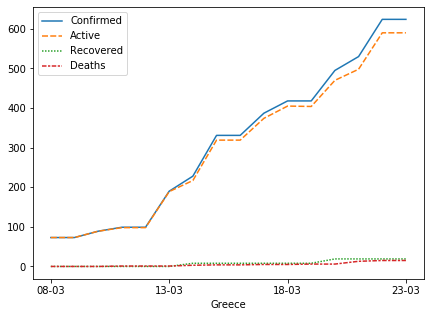


Daily growth for each types of cases



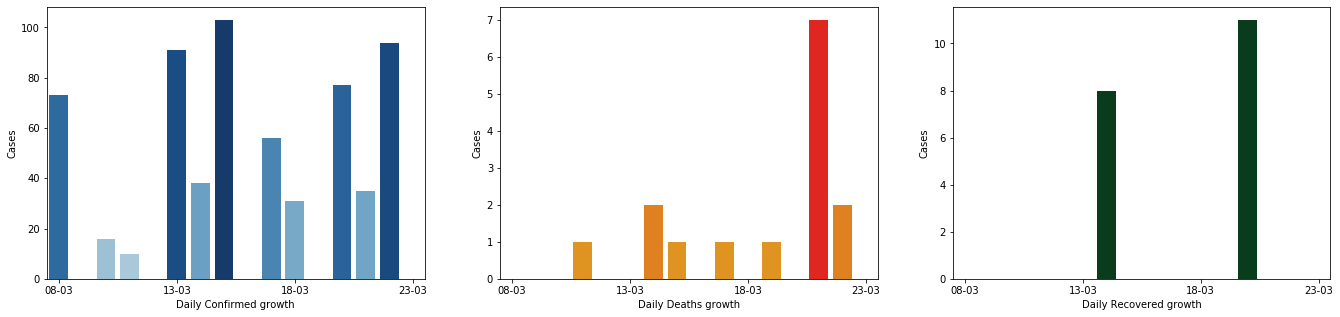

35 . Thailand
Confirmed: 599.0 
Active: 554.0 
Recovered: 44.0 
Deaths: 1.0


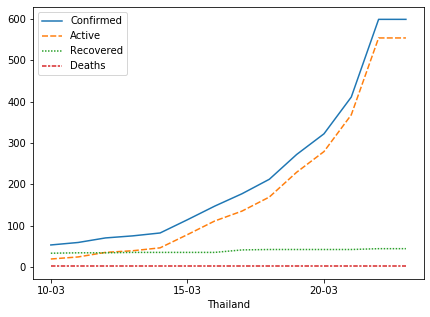


Daily growth for each types of cases



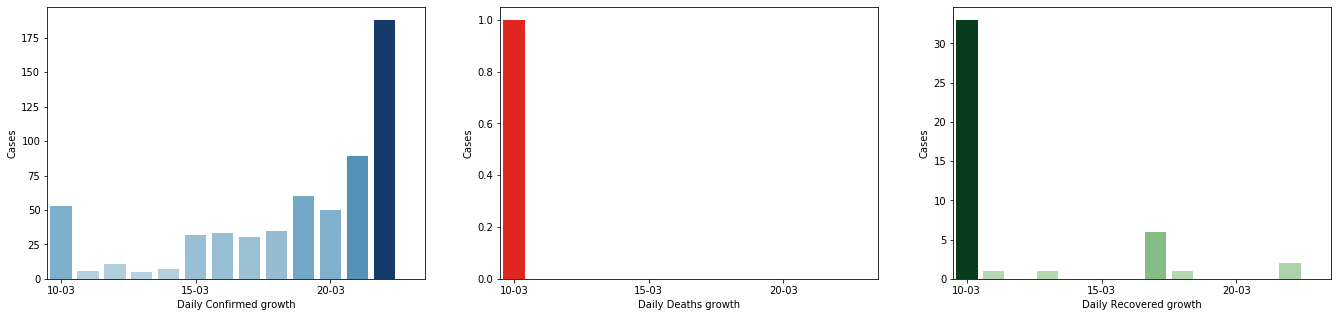

36 . Iceland
Confirmed: 568.0 
Active: 531.0 
Recovered: 36.0 
Deaths: 1.0


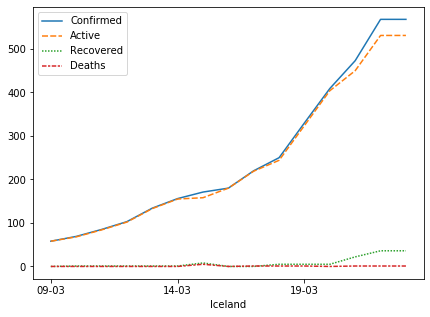


Daily growth for each types of cases



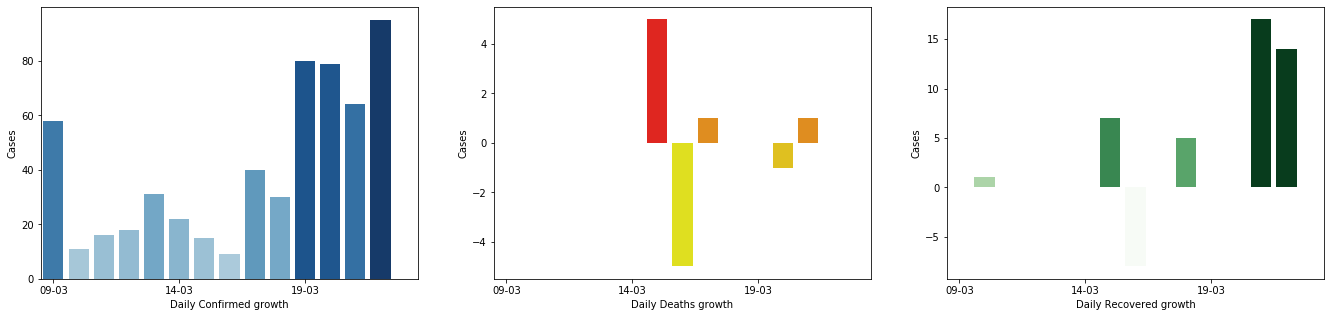

37 . Indonesia
Confirmed: 514.0 
Active: 437.0 
Recovered: 29.0 
Deaths: 48.0


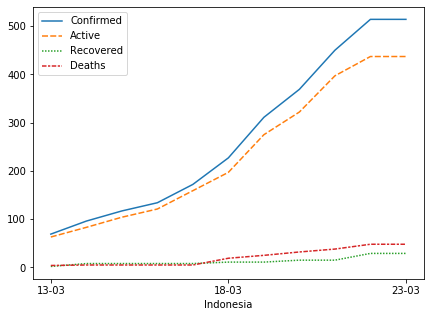


Daily growth for each types of cases



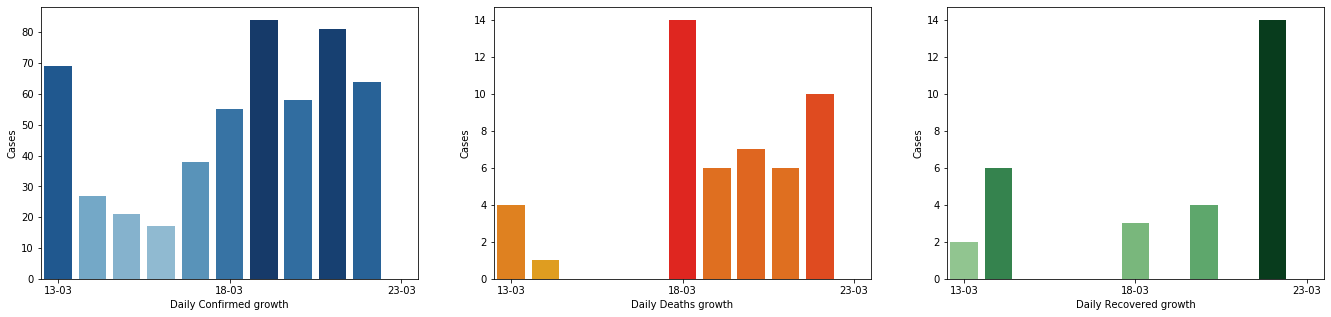

38 . Saudi Arabia
Confirmed: 511.0 
Active: 495.0 
Recovered: 16.0 
Deaths: 0.0


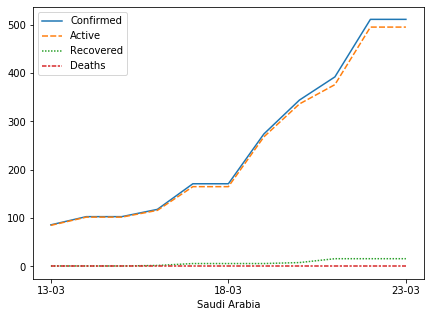


Daily growth for each types of cases



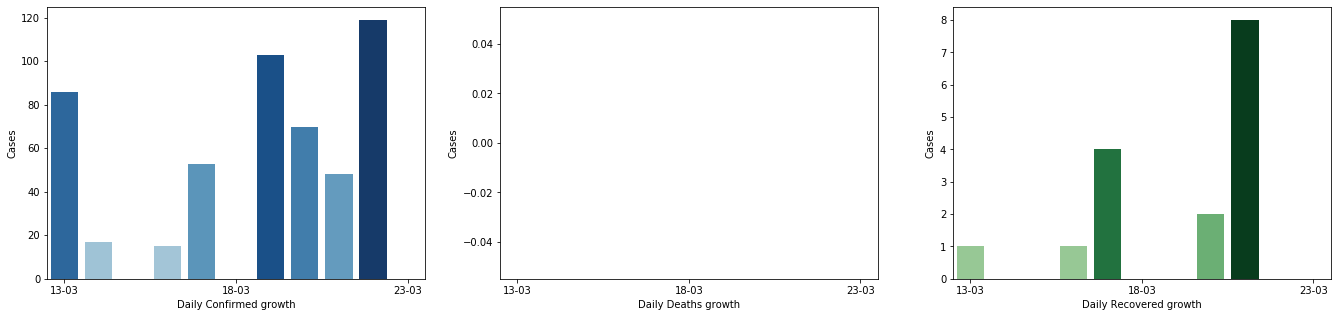

39 . Qatar
Confirmed: 494.0 
Active: 461.0 
Recovered: 33.0 
Deaths: 0.0


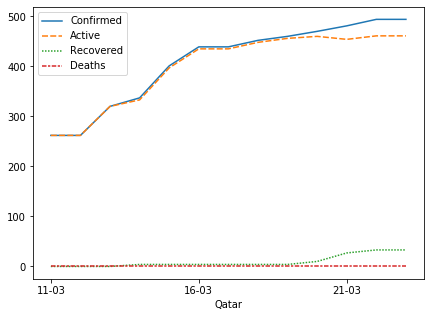


Daily growth for each types of cases



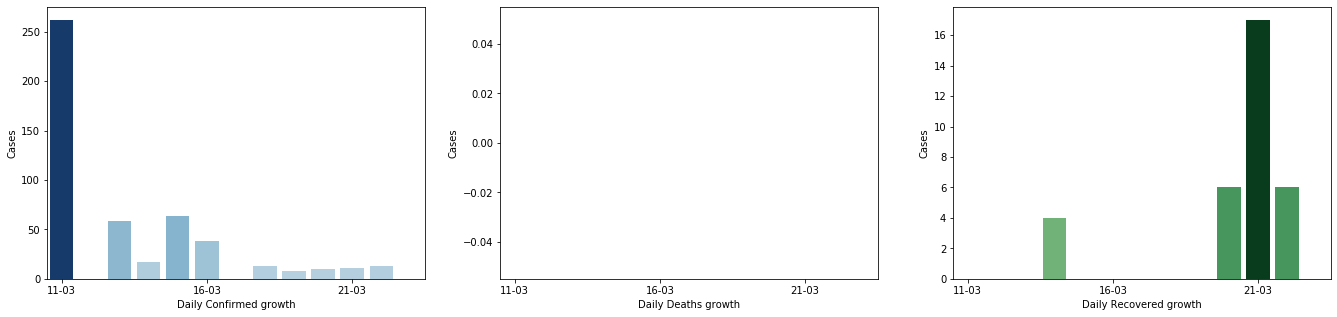

40 . Singapore
Confirmed: 455.0 
Active: 309.0 
Recovered: 144.0 
Deaths: 2.0


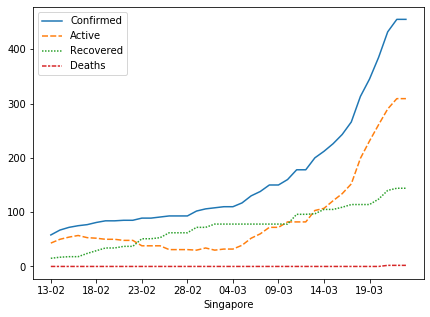


Daily growth for each types of cases



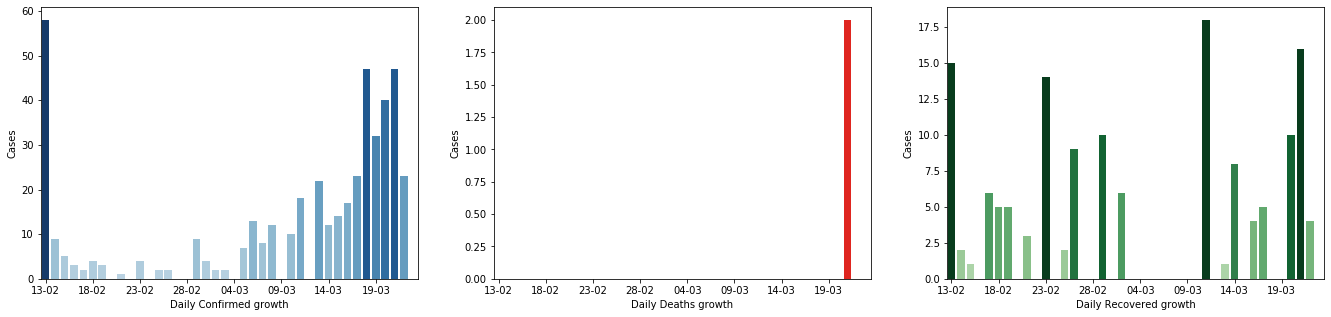

41 . Romania
Confirmed: 433.0 
Active: 366.0 
Recovered: 64.0 
Deaths: 3.0


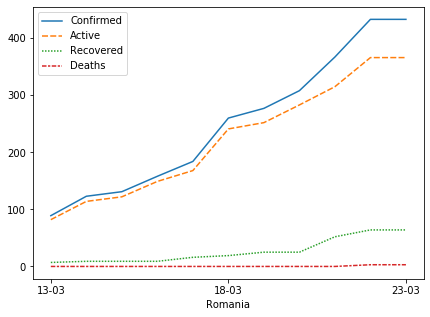


Daily growth for each types of cases



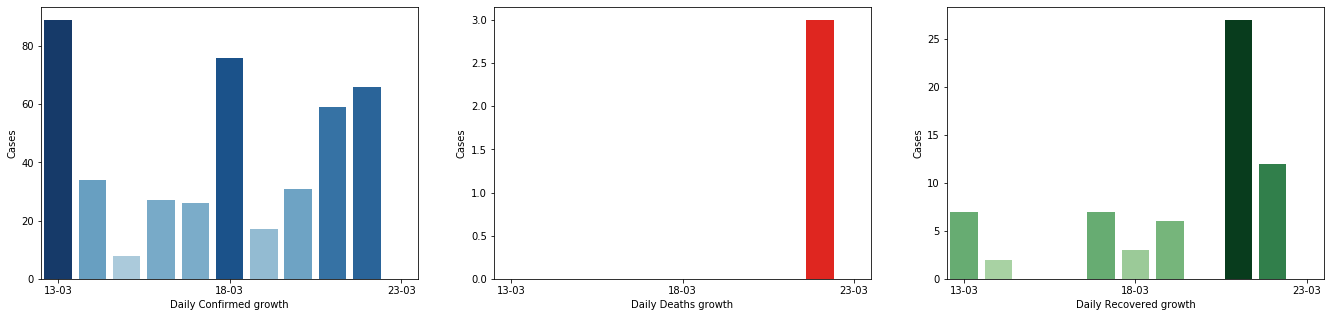

42 . Slovenia
Confirmed: 414.0 
Active: 412.0 
Recovered: 0.0 
Deaths: 2.0


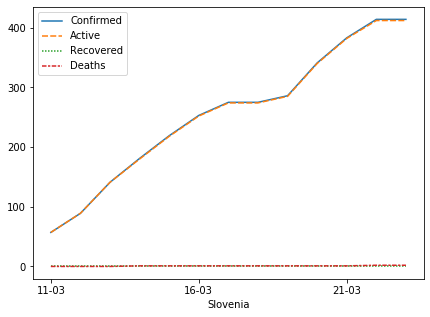


Daily growth for each types of cases



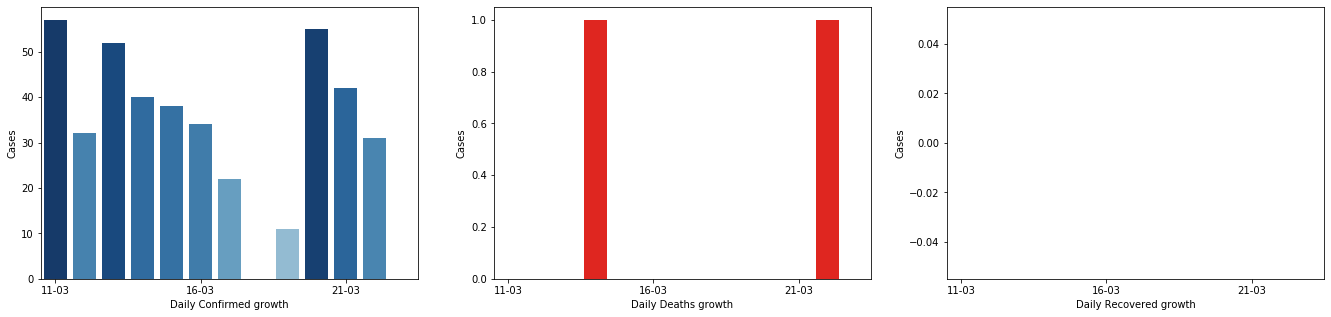

43 . India
Confirmed: 396.0 
Active: 362.0 
Recovered: 27.0 
Deaths: 7.0


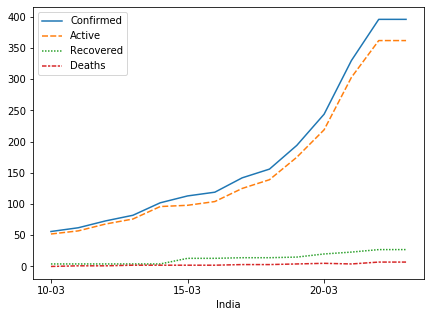


Daily growth for each types of cases



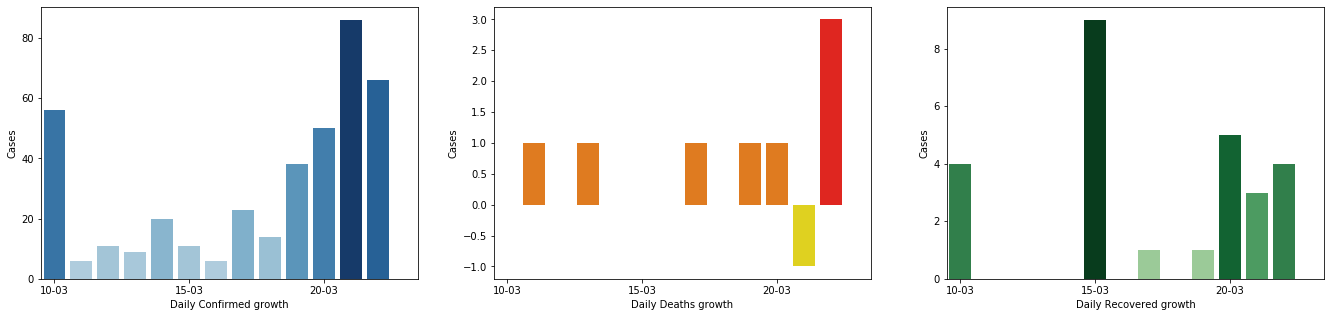

44 . Philippines
Confirmed: 380.0 
Active: 338.0 
Recovered: 17.0 
Deaths: 25.0


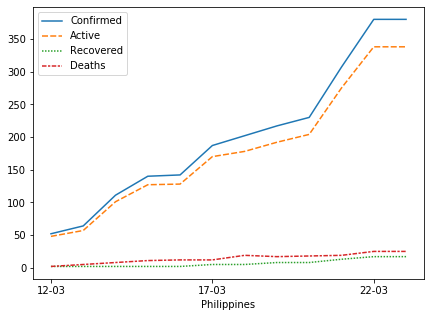


Daily growth for each types of cases



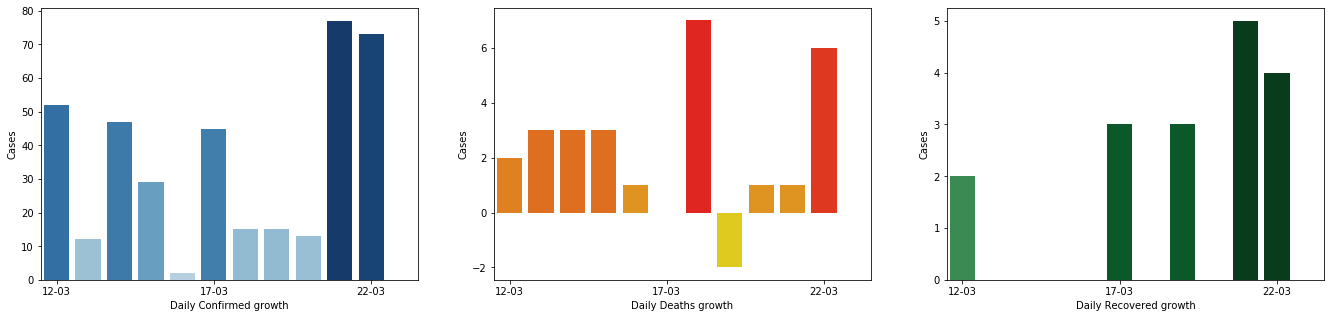

45 . Russia
Confirmed: 367.0 
Active: 351.0 
Recovered: 16.0 
Deaths: 0.0


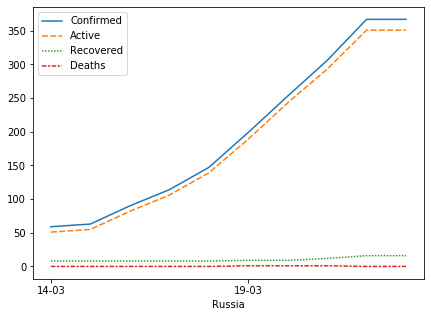


Daily growth for each types of cases



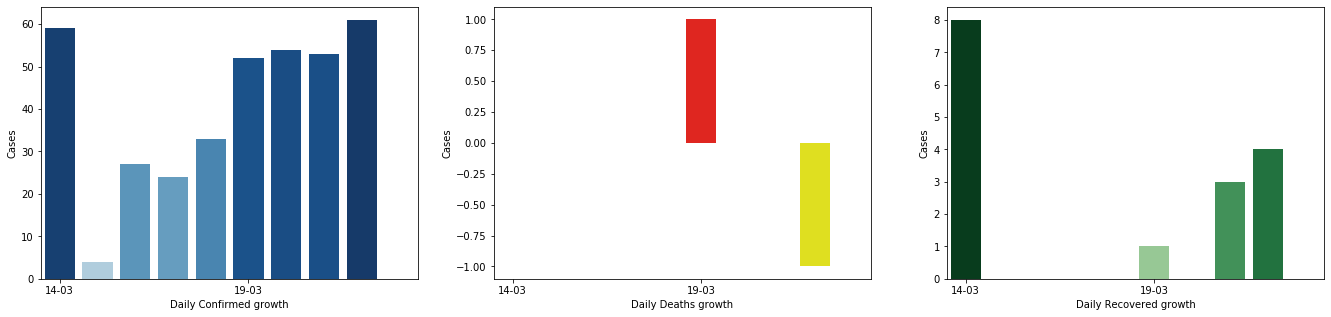

46 . Peru
Confirmed: 363.0 
Active: 357.0 
Recovered: 1.0 
Deaths: 5.0


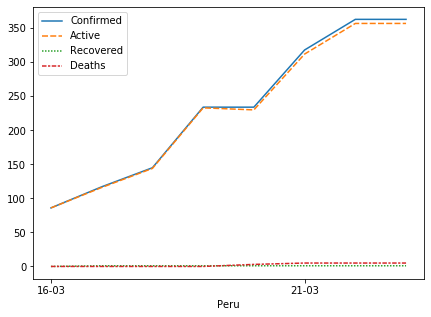


Daily growth for each types of cases



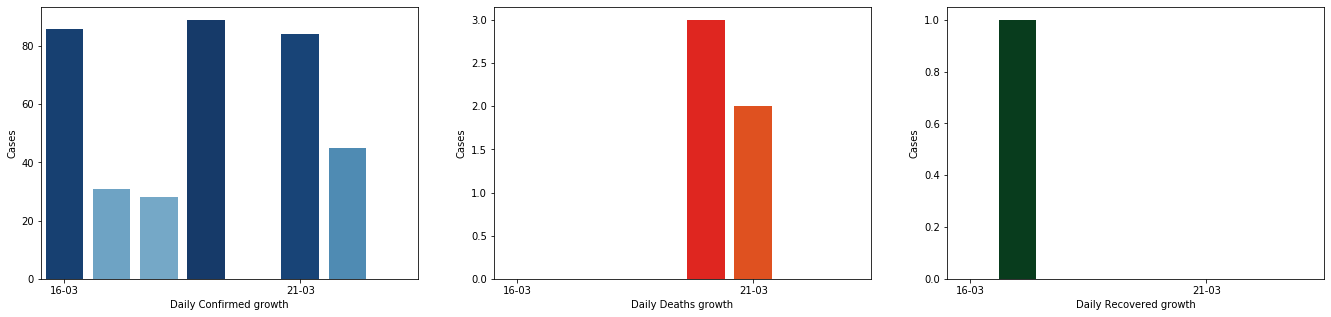

47 . Bahrain
Confirmed: 332.0 
Active: 181.0 
Recovered: 149.0 
Deaths: 2.0


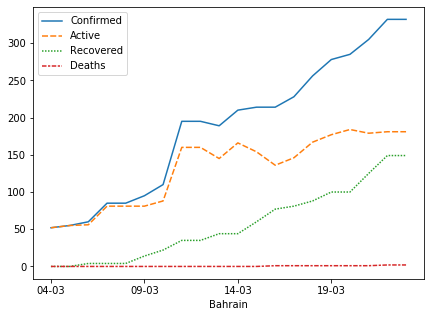


Daily growth for each types of cases



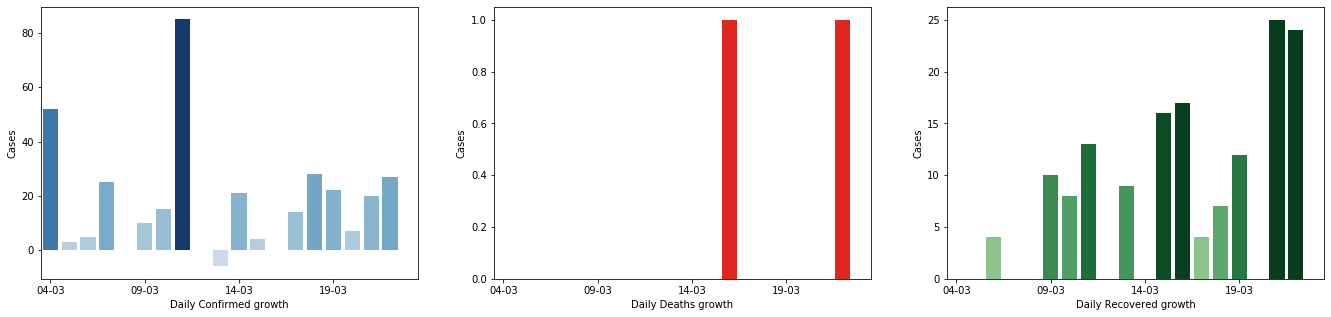

48 . Egypt
Confirmed: 327.0 
Active: 257.0 
Recovered: 56.0 
Deaths: 14.0


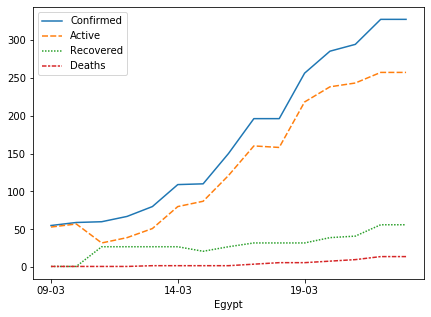


Daily growth for each types of cases



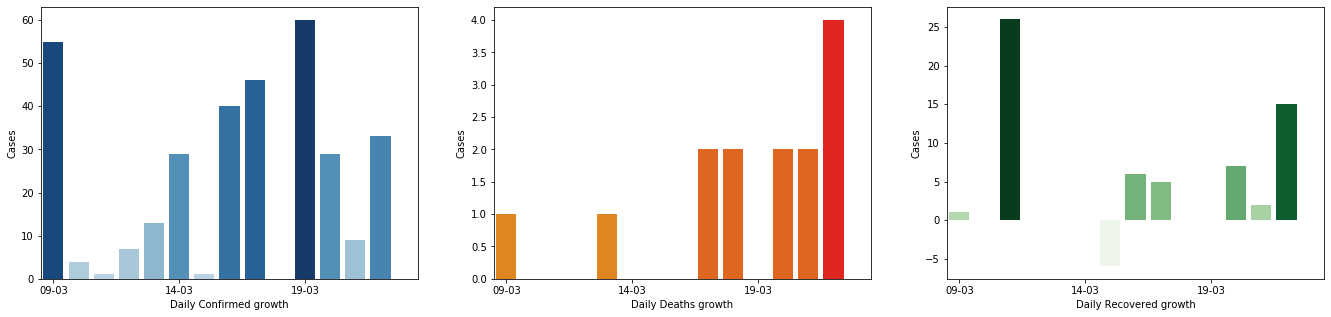

49 . Estonia
Confirmed: 326.0 
Active: 324.0 
Recovered: 2.0 
Deaths: 0.0


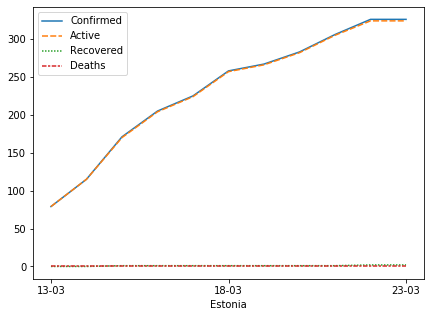


Daily growth for each types of cases



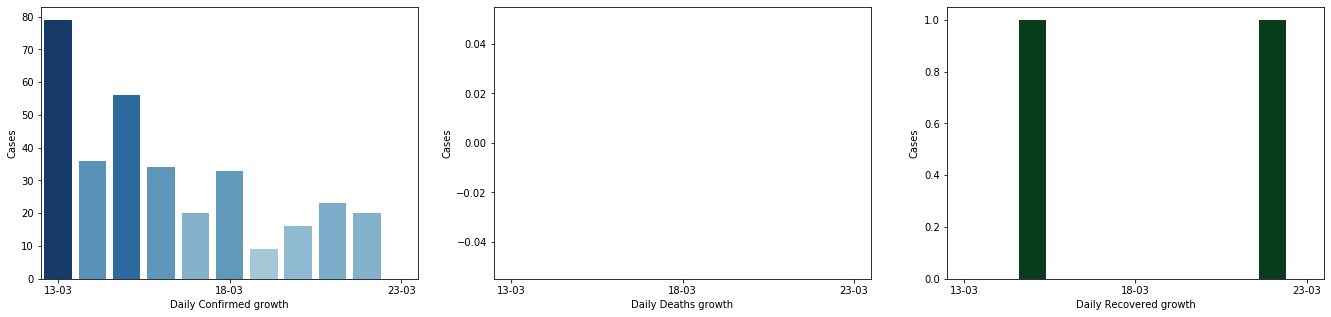

50 . South Africa
Confirmed: 274.0 
Active: 274.0 
Recovered: 0.0 
Deaths: 0.0


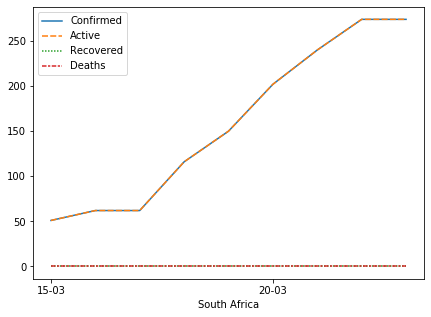


Daily growth for each types of cases



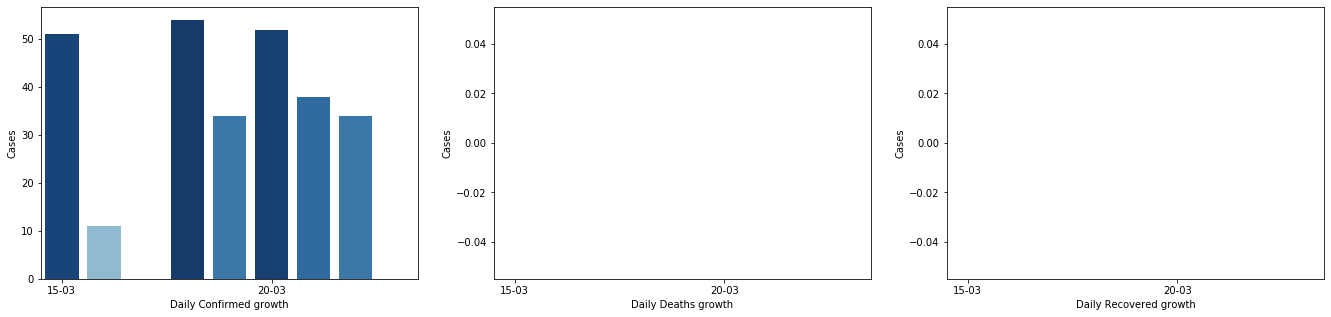

In [9]:
for index, country in enumerate(top_50.index):
    print(index+1,'.', country)
    print('Confirmed:', top_50.Confirmed[country],'\n'\
          'Active:', top_50.Active[country],'\n'\
          'Recovered:', top_50.Recovered[country],'\n'\
          'Deaths:', top_50.Deaths[country]
         )
    df, date_range = prepare_data(covid_19_df, country, 50)
    df = add_data(df)
    show_increment(df, country, date_range)